In [1]:
from scipy import optimize
import astropy.constants as const
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

%matplotlib notebook

In [2]:
class SNCompanionCollision(object):
    
    def __init__(self, a=1e13, M=1.4*const.M_sun.cgs.value, v=1e9, kappa=0.2):
        """
        parameters:
            a: binary separation in cm (default value: 1e13)
            M: ejecta mass in gram (default value: Chandrasekar mass)
            v: expansion velocity in cm/s (default value: 1e9)
            kappa: opacity in cm^2/gram (default value: 0.2)
        """
        self.a = a / 1e13
        self.M = M / (1.4*const.M_sun.cgs.value)
        self.v = v / 1e9
        self.kappa = kappa / 0.2
    
    def _AngularDependence(self, theta):
        """
        This function uses the parameterization of eq. (3) in Brown et al. 2012, ApJ, 749, 18
        parameters:
            theta: viewing angle in degrees
        return paramters:
            angular dependence factor
        """
        theta_rad = theta * 0.01745
        return (0.5 * np.cos(theta_rad) + 0.5) *\
            (0.14 * theta_rad * theta_rad - 0.4 * theta_rad + 1)

#         return 0.2075 * (0.5 * np.cos(theta_rad) + 0.5) *\
#             (0.14 * theta_rad * theta_rad - 0.4 * theta_rad + 1) * np.cos(theta_rad)
        
    def _DerivedEquation(self, t):
        """
        Eqs. (22) and (25) in Kasen 2010, ApJ, 708, 1025
        parameter:
            t: in units of days after explosion
        return parameters:
            luminosity: luminosity in ergs/s
            temperature: temperature in kelvin
        """
        luminosity = 1e43 * self.a * self.M**(0.25) * self.v**(1.75) * self.kappa**(-0.75) * t**(-0.5)
        temperature = 2.5e4 * self.a**(0.25) * self.kappa**(-35. / 36) * t**(-37. / 72)
        return luminosity, temperature
    
    def _PlanckFunction(self, wavelength, temperature):
        """
        parameters:
            wavelength: wavelength in Angstrom
            temperature: thermal temperature in Kelvin
        return paramters:
            flux density in ergs/s/cm^2/ster/Angstrom
        """
        factor = const.h.cgs.value * const.c.cgs.value / (wavelength * 1e-8 * const.k_B.cgs.value * temperature)
        flux = 2. * const.h.cgs.value * const.c.cgs.value * const.c.cgs.value / (wavelength * 1e-8)**5 /\
            (np.exp(factor) - 1) * 1e-8
        return flux
    
    def Spectrum(self, t, theta):
        """
        parameters:
            t: in units of days after explosion
            theta: viewing angle in degrees
        return parameters:
            a function to calculate spectrum at a given wavelength in units of ergs/s/ster/Angstrom
        """
        luminosity, temperature = self._DerivedEquation(t)
        f = self._AngularDependence(theta)
        func = lambda wavelength: f * luminosity * np.pi * self._PlanckFunction(wavelength, temperature) /\
                                  (const.sigma_sb.cgs.value * temperature**4)
        return func

In [3]:
from scipy import interpolate
from scipy import integrate

class Filter(object):
    
    def __init__(self, name, wavelength, transmission):
        """
        parameters:
            name: filter name
            wavelength: wavelength in Angstrom
            tranmission: in the units of per Angstrom per photon
        """
        self.name = name
        self.wavelength = wavelength
        self.transmission = transmission
        norm = integrate.quad(self._TransmissionInterpolation(),
                              self.wavelength.min(),
                              self.wavelength.max())[0]
        self.transmission /= norm
        self.wavelength_eff = 1 /\
            integrate.quad(interpolate.interp1d(self.wavelength,
                                                self.transmission,
                                                bounds_error=False,
                                                fill_value=0),
                           self.wavelength.min(),
                           self.wavelength.max())[0]
        
    def _TransmissionInterpolation(self):
        return interpolate.interp1d(self.wavelength, 
                                    self.transmission * self.wavelength, 
                                    bounds_error=False, 
                                    fill_value=0)
    
    def TransmissionCurve(self, wv):
        return self._TransmissionInterpolation()(wv)

In [4]:
import extinction_cal

class Spectrum(object):
    
    def __init__(self, wavelength, flux):
        self.wavelength = wavelength
        self.flux = flux
        
    def extinction(self, EBV, RV=3.1):
        A = extinction_cal.calALambda(self.wavelength, RV, EBV)
        self.flux *= 10**(-A/2.5)
        
    def redshift(self, z):
        self.wavelength *= (1 + z)
        self.flux /= (1 + z)
        
    def SyntheticPhotometry(self, filter_curve):
        func = lambda wv: interpolate.interp1d(self.wavelength,
                                               self.flux * filter_curve.TransmissionCurve(self.wavelength),
                                               bounds_error=False,
                                               fill_value=0)(wv)
        return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]

In [5]:
# apply it to iPTF16abc
z = 0.0234
mu = 34.89
dist = 10**(mu/5 + 1) * 3.086e+18
t_disc = 0.15  # days. First detection of iPTF16abc
mag = 21.4  # mag. First mag of iPTF16abc
local_EBV = 0.05
galactic_EBV = 0.0279

In [6]:
def ObservedMagnitude(model, theta, filter_curve, t = 1.0, redshift=z):
    wv = filter_curve.wavelength / (1 + z)
    spec_func = model.Spectrum(t, theta)
    spec = Spectrum(wv, spec_func(wv))
    spec.extinction(local_EBV)
    spec.redshift(redshift)
    spec.flux /= (4. * np.pi * dist * dist)
    spec.extinction(galactic_EBV)
    obs_flux = spec.SyntheticPhotometry(filter_curve)  # F_lambda
    obs_flux *= filter_curve.wavelength_eff * (filter_curve.wavelength_eff * 1e-8 / const.c.cgs.value) * 1e23  # F_nu in Jy
    return -2.5 * np.log10(obs_flux / 3631)  # AB mag

In [8]:
# r filter
data = np.genfromtxt('../data/filters/LCO/sdss-rp-183_eff.txt', 
                     names=["wavelength", "transmission"])
loc_r_filter_curve = Filter("LCO_r", data["wavelength"], data["transmission"])

# g-band filter
data = np.genfromtxt('../data/filters/P48/P48_g.dat', 
                     names=["wavelength", "transmission"])
filter_curve = Filter("P48_g", data["wavelength"], data["transmission"])

# U filter
data = np.genfromtxt('../data/filters/UVOT/U_UVOT_synphot.txt', 
                     names=["wavelength", "transmission"])
U_filter_curve = Filter("Swift_U", data["wavelength"], data["transmission"])

# uvw1 filter
data = np.genfromtxt('../data/filters/UVOT/UVW1_synphot.txt', 
                     names=["wavelength", "transmission"])
uvw1_filter_curve = Filter("Swift_uvw1", data["wavelength"], data["transmission"])

# uvm2 filter
data = np.genfromtxt('../data/filters/UVOT/UVM2_synphot.txt', 
                     names=["wavelength", "transmission"])
uvm2_filter_curve = Filter("Swift_uvm2", data["wavelength"], data["transmission"])

# uvw2 filter
data = np.genfromtxt('../data/filters/UVOT/UVW2_synphot.txt', 
                     names=["wavelength", "transmission"])
uvw2_filter_curve = Filter("Swift_uvw2", data["wavelength"], data["transmission"])

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


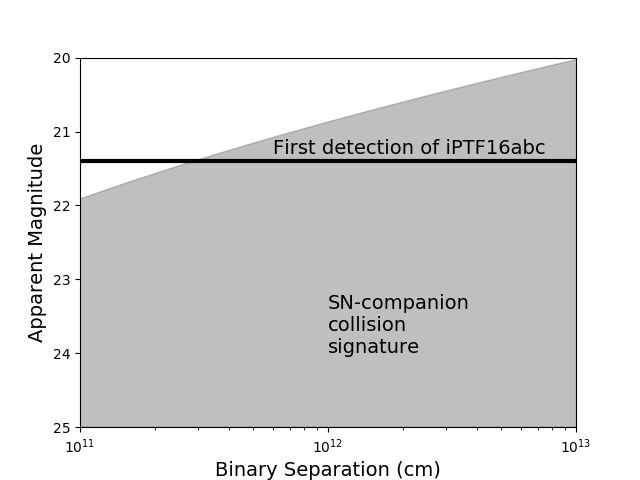

In [9]:
a_list = 10**np.linspace(11, 15, 21)
mag_list = np.ndarray(a_list.shape)
for i in range(len(a_list)):
    a = a_list[i]  # cm
    model = SNCompanionCollision(a=a, M=1.4*const.M_sun.cgs.value)
    func = lambda theta:\
        ObservedMagnitude(model, theta,  filter_curve, t = t_disc,)
    mag_list[i] = func(0)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale("log")
ax.fill_between(a_list, mag_list, 25, color='gray', alpha=0.5)
ax.hlines(mag, *ax.get_xlim(), color='k', linewidth=3)
ax.text(1e12, 24, "SN-companion\ncollision\nsignature", fontsize=14)
ax.text(6e11, 21.3, "First detection of iPTF16abc", fontsize=14)
ax.set_ylim((25, 20))
ax.set_xlim(1e11, 1e13)
ax.set_xlabel("Binary Separation (cm)", fontsize=14)
ax.set_ylabel("Apparent Magnitude", fontsize=14)

# plt.savefig("SNCompanion.pdf")

In [10]:
import tables

T_0 = 57481.21
z = 0.0234

# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

# P48 - discovery data
g_PTF = np.array([((row["time"] - T_0)/(1+z), row["mag"], row["mag_err"], row["flux"], row["flux_err"])
                 for row in h5file.root.photometry
                 if ((row["filter_name"] == b"g") & (row["telescope"] == b"P48"))],
                dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f"), ("flux", "f"), ("flux_err", "f")])
g_PTF.sort(order="time")
idx = np.where(g_PTF["mag_err"] < 99)[0]
early_lc = g_PTF[idx]

g_LCO = np.array([((row["time"] - T_0)/(1+z), row["mag"], row["mag_err"], row["flux"], row["flux_err"])
                 for row in h5file.root.photometry
                 if ((row["filter_name"] == b"g") & (row["telescope"] == b"LCO-1m"))],
                dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f"), ("flux", "f"), ("flux_err", "f")])
g_LCO.sort(order="time")

# Swift
lc_swift = np.array([((row["time"] - T_0)/(1+z), row["filter_name"], row["mag"], row["mag_err"], row["flux"], row["flux_err"])
                 for row in h5file.root.photometry
                 if ( (row["telescope"] == b"Swift") )],
                dtype=[("time", "f"), ("filter", "U4"), ("mag", "f"), ("mag_err", "f"), ("flux", "f"), ("flux_err", "f")])
lc_swift.sort(order="time")

h5file.close()

In [11]:
t_grid = np.linspace(.01,10,250)
a_grid = np.array([1e10, 1e11, 8e11, 3e11, 1.8e12])
m_g_ptf = np.ndarray((len(t_grid), len(a_grid)))
m_uvw1 = np.ndarray((len(t_grid), len(a_grid)))


for a in a_grid:
    for t in t_grid:
        model = SNCompanionCollision(a=a, M=1.4*const.M_sun.cgs.value)
        mag = ObservedMagnitude(model, 0, filter_curve, t = t, redshift=z)
        m_g_ptf[t_grid == t, a_grid == a] = mag
        mag_uvw1 = ObservedMagnitude(model, 0, uvw1_filter_curve, t = t, redshift=z)
        m_uvw1[t_grid == t, a_grid == a] = mag_uvw1




In [12]:
markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s"}

AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#061283", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#4897D8", # electric blue
             'B-V': "#89DA59", # spring green
             'g-r': "#F9DC24", # sunset #F77604", # caviar
             'r-i': "#FF0038",  # ripe tomato
             'interaction': "#626D71", # deep green
            }

In [13]:
# calculate UVW1 detection/upper limit
from astropy.time import Time
obs_time = Time("2016-04-05 09:31:58", format="iso", scale="utc")
t_ul = (obs_time.mjd - T_0)/(1+z)
m_det = -2.5 * np.log10(0.00826241/3.631e6)
m_unc_det = 1.0857 * float(0.00253829 / 0.00826241)
m_ul = -2.5 * np.log10(5 * 0.00253829/3.631e6)

<IPython.core.display.Javascript object>


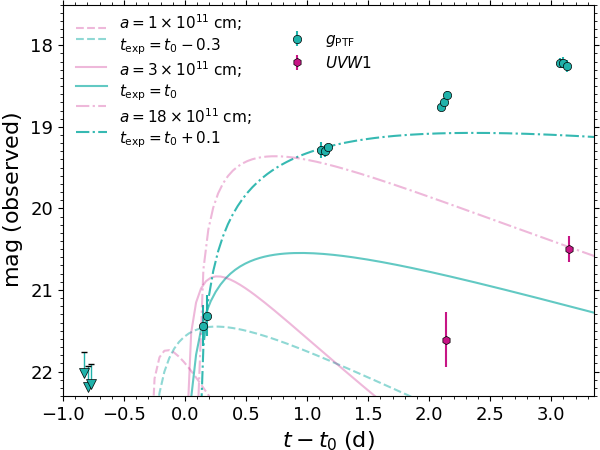

In [35]:
fig, ax = plt.subplots(figsize = (6,4.5))

# index UVW1 data
uvw1_idx = np.where(lc_swift["filter"] == "UVW1")[0]

# plot the g-band models
ax.plot(t_grid-0.3,m_g_ptf[:,1], "--",
        color = AAMcolors["g"], alpha = 0.5, 
        label= r"$a = 1 \times 10^{11} \; \mathrm{cm};$" + "\n" + r"$t_\mathrm{exp} = t_0 - 0.3$" )
ax.plot(t_grid-0.3,m_uvw1[:,1], "--",
        color = "#c71585", alpha = 0.3 
        )

ax.plot(t_grid, m_g_ptf[:,3], 
        color = AAMcolors["g"], alpha = 0.7, 
        label= r"$a = 3 \times 10^{11} \; \mathrm{cm};$" + "\n" + r"$t_\mathrm{exp} = t_0$")
ax.plot(t_grid, m_uvw1[:,3], 
        color = "#c71585", alpha = 0.3
       )

ax.plot(t_grid+.1, m_g_ptf[:,4], "-.",
        color = AAMcolors["g"], alpha = 0.9,
        label= r"$a = 18 \times 10^{11} \; \mathrm{cm};$" + "\n" + r"$t_\mathrm{exp} = t_0 + 0.1$")
ax.plot(t_grid+.1, m_uvw1[:,4], "-.",
        color = "#c71585", alpha = 0.3 
        )

# ax.plot(t_grid+.06, m_g_ptf[:,2], "-.",
#         color = "k", alpha = 0.9,
#         label= r"$a = 2 \times 10^{13} \; \mathrm{cm};$" + "\n" + r"$t_\mathrm{exp} = t_0 + 0.3$")
# ax.plot(t_grid+.06, m_uvw1[:,2], ".",
#         color = "#c71585", alpha = 0.3 
#         )

# g-band data
ax.errorbar(early_lc['time'], early_lc['mag'], early_lc['mag_err'], 
            fmt = markers["P48"], color = AAMcolors["g"], mec = "k", mew = 0.5,
            label = r"$g_\mathrm{PTF}$")

# plot the upper limits
ULoffset = 0.25
yerr_g = np.zeros((2, len(g_PTF['time'][0:6])))
yerr_g[0,:] += ULoffset

ax.errorbar(g_PTF['time'][0:6], -2.5*np.log10(g_PTF["flux_err"][0:6]*3/3631)+ULoffset, yerr = yerr_g, 
            fmt = 'v', color = AAMcolors["g"], ms = 7, 
            elinewidth=1, capsize = 0, mec = 'k', mew = 0.5)
ax.plot(g_PTF['time'][0:6], -2.5*np.log10(g_PTF["flux_err"][0:6]*3/3631), '_', 
        color = "k", mew = 1, ms = 5)

# plot the UVW1 light curve
ax.errorbar(lc_swift[uvw1_idx]['time'], lc_swift[uvw1_idx]['mag'], lc_swift[uvw1_idx]['mag_err'],
            fmt = markers["Swift"], color = "#c71585", mew = 0.5, mec = "k",
            label = r"$UVW1$")
ax.errorbar(t_ul, m_det, m_unc_det,
            fmt = markers["Swift"], color = "#c71585", mew = 0.5, mec = "k")


ax.set_ylim(22.3, 17.5)
ax.set_xlim(-1.,3.35)
ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 16)
ax.set_ylabel(r"$\mathrm{mag}\; (\mathrm{observed})$", fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
leg = ax.legend(loc = 2, fancybox = True, borderpad = 0.35, 
                labelspacing = 0.35, ncol = 2, frameon=False, 
                fontsize = 11) #, labelspacing = -0.4)

# legend hack
ax.plot([-.893, -0.645], [17.79, 17.79], "--",
        color = "#c71585", alpha = 0.3, zorder = 100 
        )
ax.plot([-.893, -0.645], [18.27, 18.27], "-",
        color = "#c71585", alpha = 0.3, zorder = 100 
        )
ax.plot([-.893, -0.645], [18.75, 18.75], "-.",
        color = "#c71585", alpha = 0.3, zorder = 100 
        )


ax.tick_params(axis='both', which='both', right=True, top=True, labelsize=13)

for textnum, t in enumerate(leg.get_texts()[0:3]):
    if textnum < 3:
        t.set_position((0,-1))
    
fig.subplots_adjust(bottom = 0.12, top = 0.99, right = 0.99, left = 0.105)

# plt.savefig('companion_lc.pdf')

In [39]:
m_ul

21.141287514440229

In [22]:
uvw1_idx = np.where(lc_swift["filter"] == "UVW1")[0]
plt.plot(t_grid-1,m_uvw1[:,1], color = AAMcolors["interaction"], alpha = 0.5)
plt.plot(t_grid, m_uvw1[:,3], color = AAMcolors["interaction"], alpha = 0.7)
plt.plot(t_grid+.3, m_uvw1[:,4], color = AAMcolors["interaction"], alpha = 0.9)

plt.plot(t_grid,m_uvw1[:,2], color = "k", alpha = 0.5)



plt.plot(lc_swift[uvw1_idx]['time'], lc_swift[uvw1_idx]['mag'], "o")

plt.ylim(22.5, 18)
plt.xlim(-1.2,3.5)

(-1.2, 3.5)

#### Calculate the extinction corrections 

For each filter assume that the spectrum of the source is a black body at $T \approx 1.3 \times 10^{4} \; \mathrm{K}$. Then calculate the extinction in that filter following this assumption.

In [64]:
# calculate the *relative* spectrum at any lambda given Teff

def PlanckFunction(wavelength, temperature):
    """
    parameters:
        wavelength: wavelength in Angstrom
        temperature: thermal temperature in Kelvin
    return paramters:
        flux density in ergs/s/cm^2/ster/Angstrom
    """
    factor = const.h.cgs.value * const.c.cgs.value / (wavelength * 1e-8 * const.k_B.cgs.value * temperature)
    flux = 2. * const.h.cgs.value * const.c.cgs.value * const.c.cgs.value / (wavelength * 1e-8)**5 /\
        (np.exp(factor) - 1) * 1e-8
    return flux



func = lambda wavelength, Teff: np.pi * PlanckFunction(wavelength, Teff) /\
            (const.sigma_sb.cgs.value * Teff**4)



In [80]:
f = func(np.linspace(2000, 5000, 3000), 14e3)

<IPython.core.display.Javascript object>


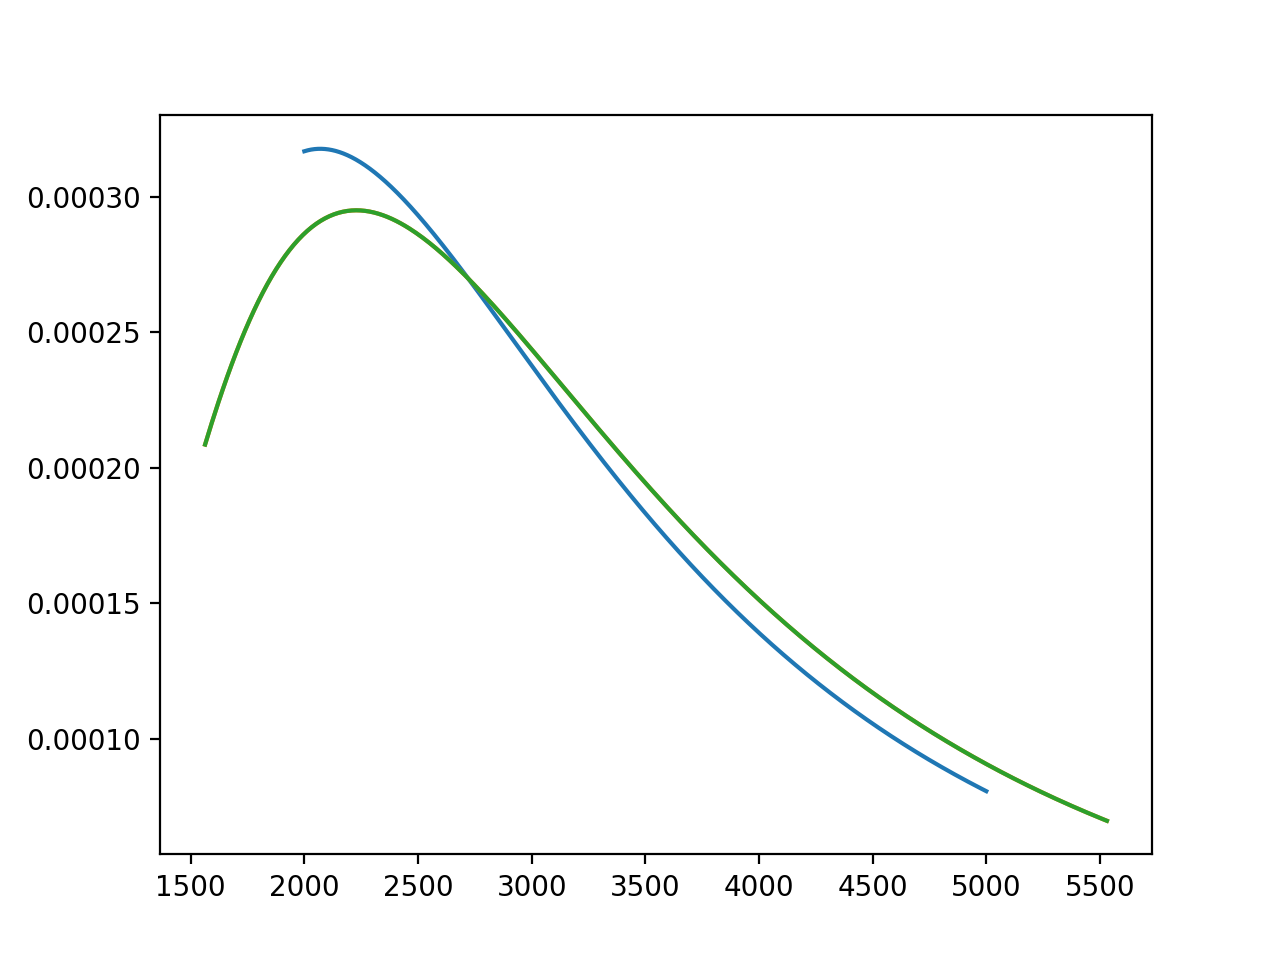

In [81]:
plt.plot(np.linspace(2000, 5000, 3000), f)

In [107]:
def ReddeningMagnitude(Teff, filter_curve, local_EBV, galactic_EBV, redshift=z):
    wv = filter_curve.wavelength / (1 + redshift)
    spec_func = lambda wavelength, Teff: np.pi * PlanckFunction(wavelength, Teff) /\
            (const.sigma_sb.cgs.value * Teff**4)
    spec = Spectrum(wv, spec_func(wv, Teff))
    red_spec = Spectrum(wv, spec_func(wv, Teff))
    red_spec.extinction(local_EBV)
    spec.redshift(redshift)
    red_spec.redshift(redshift)
    red_spec.extinction(galactic_EBV)
    obs_flux = spec.SyntheticPhotometry(filter_curve)  # F_lambda
    obs_flux *= filter_curve.wavelength_eff * (filter_curve.wavelength_eff * 1e-8 / const.c.cgs.value) * 1e23  # F_nu in Jy
    red_obs_flux = red_spec.SyntheticPhotometry(filter_curve)  # F_lambda
    red_obs_flux *= filter_curve.wavelength_eff * (filter_curve.wavelength_eff * 1e-8 / const.c.cgs.value) * 1e23  # F_nu in Jy

    return -2.5 * np.log10(red_obs_flux / 3631) + 2.5 * np.log10(obs_flux / 3631) # AB mag

In [127]:
print("In the UVW2 band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, uvw2_filter_curve, 0.05, 0.0279, redshift = z)))
print("In the UVM2 band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, uvm2_filter_curve, 0.05, 0.0279, redshift = z)))
print("In the UVW1 band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, uvw1_filter_curve, 0.05, 0.0279, redshift = z)))
print("In the U band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, U_filter_curve, 0.05, 0.0279, redshift = z)))
print("In the g_PTF band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, filter_curve, 0.05, 0.0279, redshift = z)))
print("In the r band A_filt = {:.4f} mag".format(ReddeningMagnitude(1.3e4, loc_r_filter_curve, 0.05, 0.0279, redshift = z)))

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In the UVW2 band A_filt = 0.6248 mag
In the UVM2 band A_filt = 0.6630 mag
In the UVW1 band A_filt = 0.5485 mag
In the U band A_filt = 0.3948 mag
In the g_PTF band A_filt = 0.2930 mag
In the r band A_filt = 0.2086 mag
